# Groundwater Prediction with simple 2D-CNN

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

In [1]:
import os
#don't use GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal_array
import glob
import random
import pandas as pd

In [3]:
data_drive = r'F:/'

In [4]:
regnie_path = data_drive + r'GruV-Net/data/precipitation/GTiff/'
ground_path = data_drive + r'GruV-Net/data/groundwater_levels_preprocessed_hesse/daily/'

*Trainingszeitraum: 5 Jahre (2010-2014), Testzeitraum: 1 Jahr (2015)*

In [6]:
ground_files_train = glob.glob(ground_path+r'GTiff/'+'2010-*.tif') + glob.glob(ground_path+r'GTiff/'+'2011-*.tif') + glob.glob(ground_path+r'GTiff/'+'2012-*.tif') + glob.glob(ground_path+r'GTiff/'+'2013-*.tif') + glob.glob(ground_path+r'GTiff/'+'2014-*.tif')
ground_files_train = list(map(os.path.basename, ground_files_train))
ground_files_train.sort()

In [7]:
regnie_files_train = glob.glob(regnie_path+'ra10*.tif') + glob.glob(regnie_path+'ra11*.tif') + glob.glob(regnie_path+'ra12*.tif') + glob.glob(regnie_path+'ra13*.tif') + glob.glob(regnie_path+'ra14*.tif')
regnie_files_train = list(map(os.path.basename, regnie_files_train))
regnie_files_train.sort()

In [8]:
ground_files_test = glob.glob(ground_path+r'GTiff/'+'2015-*.tif')
ground_files_test = list(map(os.path.basename, ground_files_test))
ground_files_test.sort()

In [9]:
regnie_files_test = glob.glob(regnie_path+'ra15*.tif')
regnie_files_test = list(map(os.path.basename, regnie_files_test))
regnie_files_test.sort()

## Baseline
absichtlich "naives" CNN als Ausgangspunkt und Testmöglichkeit.
- max. Auflösung (ca. 1$km^2$ ro Zelle)
- keine Vorauswahl von Stationen / Herausfiltern von fehlenden Werten
- kein Padding
- Eingabe: Messstände und Niederschlag der letzten ~30 Tage (4 Grundwasserdaten von aufeinander folgenden Daten, 28 Tage Niederschlag ab 1 Woche vor ersten Grundwasserdaten)
- Ausgabe: vorhergesagte Messstände für Woche nach Eingabezeitraum
- Zufällige Auswahl von Trainingseingaben aus Trainingszeitraum

In [ ]:
def generate_instances(n, ground_files, regnie_files, normalize=True):
    x = np.ndarray(shape=(n, 252, 142, 32))
    y = np.ndarray(shape=(n, 1268))
    for i in range(n):
        r = random.randrange(0, len(ground_files)-4)
        ground_stack = np.ndarray(shape=(4, 252, 142))
        for j in range(r, r+4):
            ground_data = gdal_array.LoadFile(ground_path+r'GTiff/'+ground_files[j])
            #print(ground_files[j])
            ground_stack[j-r] = ground_data

        regnie_index = regnie_files.index('ra'+ground_files[r][2:4]+ground_files[r][5:7]+ground_files[r][8:10]+'.tif')
        regnie_stack = np.ndarray(shape=(28, 252, 142))
        for j in range(regnie_index-7, regnie_index+21):
            regnie_data = gdal_array.LoadFile(regnie_path+regnie_files[j])
            #print(regnie_files[j])
            regnie_stack[j-(regnie_index-7)] = regnie_data

        if normalize:
            ground_stack = tf.keras.utils.normalize(ground_stack)
            regnie_stack = tf.keras.utils.normalize(regnie_stack)
        x[i] = np.transpose(np.concatenate((ground_stack, regnie_stack)), (1, 2, 0))
        y[i] = pd.read_csv(ground_path+r'csv/'+ground_files[r+4][:-4]+'.csv').fillna(0)['VAL'].to_numpy()
    return x, y

In [ ]:
x_train, y_train = generate_instances(1500, ground_files_train, regnie_files_train)
x_test, y_test = generate_instances(150, ground_files_test, regnie_files_test)

In [ ]:
x_train.shape

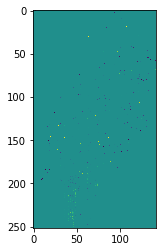

In [16]:
plt.imshow(np.transpose(x_train, (0, 3, 1, 2))[0][3])

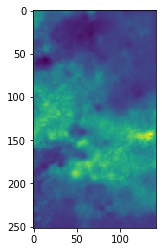

In [17]:
plt.imshow(np.transpose(x_train, (0, 3, 1, 2))[0][20])

In [17]:
def create_Simple_2DCNN():
    return tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=5, strides=(3, 3), activation='relu', input_shape=(252, 142, 32)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1268)
])
GruV_Net_Simple_2DCNN = create_Simple_2DCNN()
opt = tf.keras.optimizers.Adam(learning_rate = 0.000001, epsilon=0.1)
GruV_Net_Simple_2DCNN.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
GruV_Net_Simple_2DCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 83, 46, 32)        25632     
_________________________________________________________________
flatten_1 (Flatten)          (None, 122176)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               62554624  
_________________________________________________________________
dense_3 (Dense)              (None, 1268)              650484    
Total params: 63,230,740
Trainable params: 63,230,740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = GruV_Net_Simple_2DCNN.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
training_mae = hist.history['mean_absolute_error']
test_mae = hist.history['val_mean_absolute_error']

plt.plot(training_mae, 'r--')
plt.plot(test_mae, 'b-')
plt.legend(['Training MAE', 'Test MAE'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()

## Messtände um Stationshöhe bereinigen
Ziel ist das reduzieren des Einfluss von großen Werten. Ich glaub das eingentlich richtige wäre es die Werte ins Verhältnis zum jeweiligen Stations-Durchschnittswert zu setzen.

*Gibt es eine dafür geeignete Normalisierung?*

*evtl. andere Höhe besser? Durchschnittshöhe des Messwerts? Was ist Brunnen Sohltiefe, F Oberkante, F Unterkante?*

In [11]:
station_elevation_raster = gdal_array.LoadFile(data_drive + r'GruV-Net/data/Messpunkthoehe_raster.tif')
station_elevation_list = pd.merge(pd.read_csv(ground_path+r'csv/2010-01-02.csv'), pd.read_excel(data_drive + r'GruV-Net/data/Stammdaten_HE.xlsx'), how='left', left_on='ProjID', right_on='Proj_ID')['MESSPUNKTHOEHE']

In [12]:
def generate_leveled_instances(n, ground_files, regnie_files, normalize=True):
    x = np.ndarray(shape=(n, 252, 142, 32))
    y = np.ndarray(shape=(n, 1268))
    for i in range(n):
        r = random.randrange(0, len(ground_files)-4)
        ground_stack = np.ndarray(shape=(4, 252, 142))
        for j in range(r, r+4):
            ground_data = gdal_array.LoadFile(ground_path+r'GTiff/'+ground_files[j])
            #print(ground_files[j])
            ground_stack[j-r] = np.subtract(ground_data, station_elevation_raster, where= ground_data!=0.0)

        regnie_index = regnie_files.index('ra'+ground_files[r][2:4]+ground_files[r][5:7]+ground_files[r][8:10]+'.tif')
        regnie_stack = np.ndarray(shape=(28, 252, 142))
        for j in range(regnie_index-7, regnie_index+21):
            regnie_data = gdal_array.LoadFile(regnie_path+regnie_files[j])
            #print(regnie_files[j])
            regnie_stack[j-(regnie_index-7)] = regnie_data

        if normalize:
            ground_stack = tf.keras.utils.normalize(ground_stack)
            regnie_stack = tf.keras.utils.normalize(regnie_stack)
        x[i] = np.transpose(np.concatenate((ground_stack, regnie_stack)), (1, 2, 0))
        y_temp = pd.read_csv(ground_path+r'csv/'+ground_files[r+4][:-4]+'.csv').fillna(0)['VAL'].to_numpy()
        y[i] = np.subtract(y_temp, station_elevation_list, where= y_temp!=0.0)
    return x, y

In [14]:
x_train, y_train = generate_leveled_instances(1000, ground_files_train, regnie_files_train)
x_test, y_test = generate_leveled_instances(100, ground_files_test, regnie_files_test)

In [15]:
hist_lvl = GruV_Net_Simple_2DCNN.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Train on 1000 samples, validate on 100 samples
Epoch 1/10
1000/1000 [==============================] - 60s 60ms/sample - loss: 7152.1201 - mean_absolute_error: 46.0950 - val_loss: 3091.8610 - val_mean_absolute_error: 27.9870
Epoch 2/10
1000/1000 [==============================] - 40s 40ms/sample - loss: 2012.2595 - mean_absolute_error: 20.2982 - val_loss: 2671.6945 - val_mean_absolute_error: 19.3927
Epoch 3/10
1000/1000 [==============================] - 37s 37ms/sample - loss: 1593.3246 - mean_absolute_error: 13.7481 - val_loss: 2679.3413 - val_mean_absolute_error: 17.2986
Epoch 4/10
1000/1000 [==============================] - 41s 41ms/sample - loss: 1563.9920 - mean_absolute_error: 12.8295 - val_loss: 2687.5456 - val_mean_absolute_error: 16.7924
Epoch 5/10
1000/1000 [==============================] - 38s 38ms/sample - loss: 1546.0990 - mean_absolute_error: 12.7222 - val_loss: 2679.4967 - val_mean_absolute_error: 16.7749
Epoch 6/10
1000/1000 [==============================] - 41s 41m

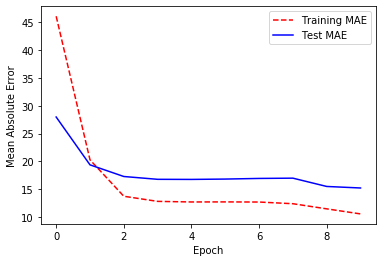

In [16]:
training_mae = hist_lvl.history['mean_absolute_error']
test_mae = hist_lvl.history['val_mean_absolute_error']

plt.plot(training_mae, 'r--')
plt.plot(test_mae, 'b-')
plt.legend(['Training MAE', 'Test MAE'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()

## In Verhältnis setzen zu Referenzzeitpunkt

In [11]:
from sklearn.preprocessing import StandardScaler

In [8]:
reference_raster = gdal_array.LoadFile(ground_path+r'GTiff/2010-01-02.tif')
reference_list =  pd.read_csv(ground_path+r'csv/2010-01-02.csv').fillna(0)['VAL'].to_numpy()

---
** RASTER HAT MEHR DATENPUNKTE ALS EIGENTLICH VORHANDEN! **

In [10]:
x_raster = gdal_array.LoadFile(ground_path+r'GTiff/2010-01-02.tif')
x_list =  pd.read_csv(ground_path+r'csv/2010-01-02.csv')['VAL']

In [12]:
np.count_nonzero(~np.isnan(x_list))

833

In [13]:
np.count_nonzero(x_raster)

1114

---

In [13]:
def generate_relative_instances(n, ground_files, regnie_files):
    x = np.ndarray(shape=(n, 252, 142, 32))
    y = np.ndarray(shape=(n, 1268))
    for i in range(n):
        r = random.randrange(0, len(ground_files)-4)
        ground_stack = np.ndarray(shape=(4, 252, 142))
        for j in range(r, r+4):
            ground_data = gdal_array.LoadFile(ground_path+r'GTiff/'+ground_files[j])
            #print(ground_files[j])
            ground_stack[j-r] = StandardScaler(with_mean=False).fit_transform(np.subtract(ground_data, reference_raster, where= ground_data!=0.0))

        regnie_index = regnie_files.index('ra'+ground_files[r][2:4]+ground_files[r][5:7]+ground_files[r][8:10]+'.tif')
        regnie_stack = np.ndarray(shape=(28, 252, 142))
        for j in range(regnie_index-7, regnie_index+21):
            regnie_data = gdal_array.LoadFile(regnie_path+regnie_files[j])
            #print(regnie_files[j])
            regnie_stack[j-(regnie_index-7)] = StandardScaler().fit_transform(regnie_data)

        x[i] = np.transpose(np.concatenate((ground_stack, regnie_stack)), (1, 2, 0))
        y_temp = pd.read_csv(ground_path+r'csv/'+ground_files[r+4][:-4]+'.csv').fillna(0)['VAL'].to_numpy()
        y[i] = np.subtract(y_temp, reference_list, where= y_temp!=0.0)
    return x, StandardScaler(with_mean=False).fit_transform(y)

In [14]:
x_train, y_train = generate_relative_instances(500, ground_files_train, regnie_files_train)
x_test, y_test = generate_relative_instances(100, ground_files_test, regnie_files_test)

In [18]:
hist_rel = GruV_Net_Simple_2DCNN.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size= 10)

Train on 500 samples, validate on 100 samples
Epoch 1/10
370/500 [=====================>........] - ETA: 1s - loss: nan - mean_absolute_error: nan

KeyboardInterrupt: 

In [16]:
training_mae = hist_rel.history['mean_absolute_error']
test_mae = hist_rel.history['val_mean_absolute_error']

plt.plot(training_mae, 'r--')
plt.plot(test_mae, 'b-')
plt.legend(['Training MAE', 'Test MAE'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()

NameError: name 'hist_rel' is not defined